<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraires-and-notebook-formatting" data-toc-modified-id="Libraires-and-notebook-formatting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraires and notebook formatting</a></span><ul class="toc-item"><li><span><a href="#Ipython-notebook-magic" data-toc-modified-id="Ipython-notebook-magic-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ipython notebook magic</a></span></li><li><span><a href="#Python-libraries" data-toc-modified-id="Python-libraries-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Python libraries</a></span></li><li><span><a href="#Plotting-style" data-toc-modified-id="Plotting-style-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plotting style</a></span></li></ul></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Least-Squares-linear-model" data-toc-modified-id="Least-Squares-linear-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Least Squares linear model</a></span></li><li><span><a href="#Hypothesis-testing" data-toc-modified-id="Hypothesis-testing-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Hypothesis testing</a></span><ul class="toc-item"><li><span><a href="#Correlation-significance" data-toc-modified-id="Correlation-significance-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Correlation significance</a></span></li></ul></li><li><span><a href="#Bootstrapping" data-toc-modified-id="Bootstrapping-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Bootstrapping</a></span><ul class="toc-item"><li><span><a href="#Correlation-significance" data-toc-modified-id="Correlation-significance-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Correlation significance</a></span></li><li><span><a href="#Slope-and-intercept-estimates" data-toc-modified-id="Slope-and-intercept-estimates-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Slope and intercept estimates</a></span></li></ul></li><li><span><a href="#Bayes-inference" data-toc-modified-id="Bayes-inference-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Bayes inference</a></span></li><li><span><a href="#Summary-of-the-results" data-toc-modified-id="Summary-of-the-results-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Summary of the results</a></span></li></ul></li></ul></div>

# Libraires and notebook formatting

## Ipython notebook magic

In [36]:
%matplotlib inline

## Python libraries

In [58]:
import pandas as pd
import datetime
import itertools
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.colors
from matplotlib.colors import ListedColormap
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from statsmodels.formula.api import ols
import pymc3 as pm
from scipy import optimize

## Plotting style

In [38]:
colors = pd.read_table('../../2017.01.14-EMP/data/rgb.txt', skiprows=[0], 
                       header=None)

colors.drop(2, axis = 1, inplace = True)
colors.columns = ['color', 'code']

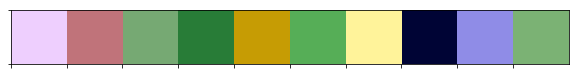

In [39]:
random_ind = np.array(random.sample(range(colors.shape[0]), 10))
palette = sns.xkcd_palette(colors.loc[random_ind,'color'].values)
sns.palplot(palette)
my_cmap = ListedColormap(palette.as_hex())

# Data analysis

## Generate data

First let's define underlying data-generating process.

In [40]:
y0 = lambda k, x, a: k*x + a

Distribution parameters

In [41]:
k = 5
a = 0
N = 100
s = 3

Now let's sample the data while adding normally distributed random noise.

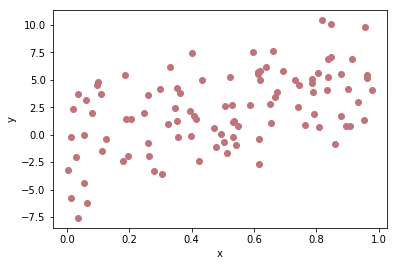

In [42]:
x = np.random.ranf((N))
y = y0(k, x, a) + np.random.normal(0, s, N)
plt.plot(x, y, 'o', color = palette[1])
plt.xlabel('x')
_ = plt.ylabel('y')

## Least Squares linear model

Fit the linear regression to our data.

In [43]:
p, cov = np.polyfit(x, y, 1, cov=True)

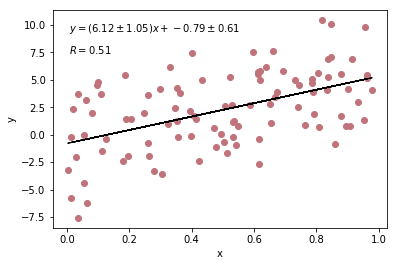

In [55]:
plt.plot(x, y, 'o', color = palette[1])
plt.plot(x, p[0]*x + p[1], linestyle = '-',color = 'k', linewidth=1.0)
plt.xlabel('x')
plt.ylabel('y')
_ = plt.annotate('$y = ({0} \pm {1})x + {2}\pm {3}$'.format(round(p[0],2), 
                                                         round(cov[0,0]**0.5,2), 
                                                         round(p[1],2), 
                                                         round(cov[1,1]**0.5,2)), 
             xy = (0.05, 0.9), 
            xycoords = 'axes fraction')
_ = plt.annotate('$R = {}$'.format(round(np.corrcoef(x, y)[0,1],2)), 
             xy = (0.05, 0.8), 
            xycoords = 'axes fraction')

## Hypothesis testing

### Correlation significance

Let's calculate correlation coefficient and it's p-value

In [47]:
print('R = {}, p = {}'.format(
    round(scipy.stats.pearsonr(x, y)[0],2), 
    round(scipy.stats.pearsonr(x, y)[1],7)))

R = 0.51, p = 1e-07


[scipy.stats.pearsonr(x, y)](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) returns pearson correlation coefficient and p-value from two-tailed t-test. That means that the probability of observing correlation coefficient $R \geq 0.42$ or $R \leq -0.42$ for two uncorrelated variables is on the order of 1 out of 100000. And therefore we can reject our null hypothesis that x and y are uncorrelated.

Let's see what is actually happenning behind the scenes. First we calculate t statistics, then we find the p-value of that statistics from the Student t-distribution with N-2 degrees of freedom.

In [48]:
t_stat=lambda r, n: r*(n - 2)**0.5/(1-r**2)**0.5
t = t_stat(scipy.stats.pearsonr(x, y)[0], N)
p_value = (1 - scipy.stats.t.cdf(t, df = N-2))*2
print('p = {}'.format(
    round(p_value,7)))

p = 1e-07


## Bootstrapping

### Correlation significance

To measure significance of pairwise relationships between x and y with bootstrapping let's see what distribution of correlation coefficients we get if we randomly shuffle y variable.

In [49]:
R = []
ind = np.arange(N)
for i in range(5000):
    np.random.seed()
    np.random.shuffle(ind)
    R.append(np.corrcoef(x, y[ind])[0,1])

Example of the distribution

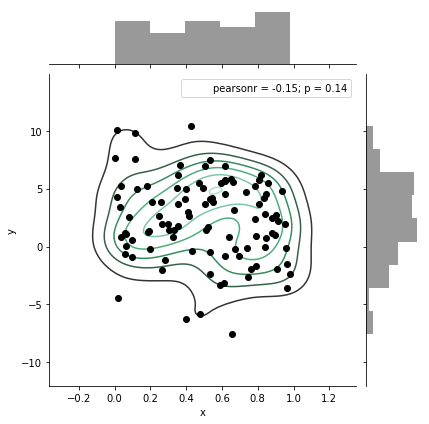

In [50]:
xy = pd.DataFrame({'x':x, 'y':y[ind]})
g = (sns.jointplot("x", "y",
    data=xy, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=6))

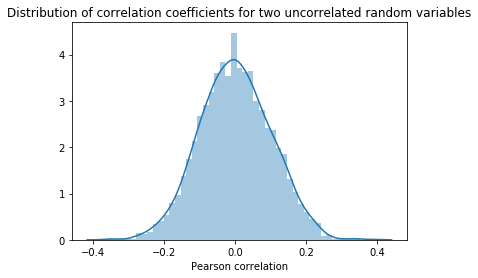

In [51]:
plt.title('Distribution of correlation coefficients for two uncorrelated random variables')
sns.distplot(R)
_ = plt.xlabel('Pearson correlation')

In [52]:
p_manual = (1 - scipy.stats.norm.cdf(scipy.stats.pearsonr(x, y)[0], 
                          loc=np.mean(R), 
                          scale=np.std(R)))*2
print('p = {}'.format(round(p_manual, 7)))

p = 4e-07


### Slope and intercept estimates

Let's generate new samples from our distribution by sampling x and y with replacement.

In [53]:
slopes = []
intercepts = []
for i in range(1000):
    np.random.seed()
    ind = np.random.choice(np.arange(N), N)
    p_bs = np.polyfit(x[ind], y[ind], 1)
    slopes.append(p_bs[0])
    intercepts.append(p_bs[1])

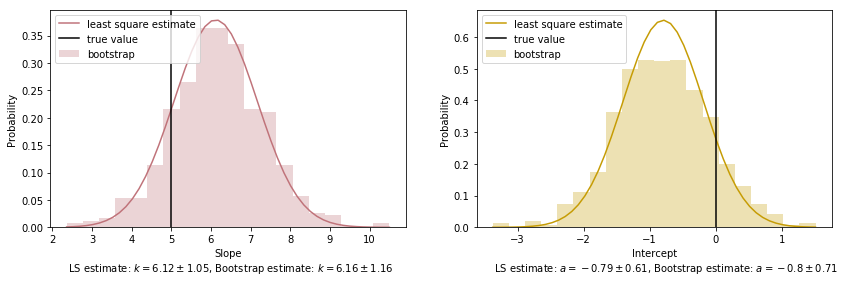

In [68]:
plt.figure(figsize=(14,4))
plt.subplot(121)
_ = plt.hist(slopes, normed=True,color = palette[1], 
             label = 'bootstrap', alpha = 0.3, bins = 20)
plt.plot(np.linspace(min(slopes), max(slopes)), 
         scipy.stats.norm.pdf(np.linspace(min(slopes), max(slopes)), 
         scale = cov[0,0]**0.5, loc = p[0]), '-',
         color = palette[1],
        label = 'least square estimate')

plt.axvline(k, color = 'k', label = 'true value')
_ = plt.annotate(r'LS estimate: $k = {0} \pm {1}$, Bootstrap estimate: $k = {2} \pm {3}$'.format(
                                                         round(p[0],2), 
                                                         round(cov[0,0]**0.5,2), 
                                                         round(np.mean(slopes),2), 
                                                         round(np.std(slopes),2)),
                 xy = (0.05, -0.2), 
                xycoords = 'axes fraction')

plt.xlabel('Slope')
plt.ylabel('Probability')
plt.legend(loc='upper left', bbox_to_anchor=(0., 1))

plt.subplot(122)
_ = plt.hist(intercepts, normed=True, color = palette[4], 
             label = 'bootstrap', alpha = 0.3, bins = 20)

plt.plot(np.linspace(min(intercepts), max(intercepts)), 
        scipy.stats.norm.pdf(np.linspace(min(intercepts), max(intercepts)), 
         scale = cov[1,1]**0.5, loc = p[1]), '-',
         color = palette[4],
        label = 'least square estimate')
plt.axvline(a, color = 'k', label = 'true value')

_ = plt.annotate(r'LS estimate: $a = {0} \pm {1}$, Bootstrap estimate: $a = {2}\pm {3}$'.format(
                                                         round(p[1],2), 
                                                         round(cov[1,1]**0.5,2),
                                                         round(np.mean(intercepts),2), 
                                                         round(np.std(intercepts),2)),
                xy = (0.05, -0.2), 
                xycoords = 'axes fraction')

plt.xlabel('Intercept')
plt.ylabel('Probability')
plt.legend(loc='upper left', bbox_to_anchor=(0., 1))

As you can see both bootstrapping and least squares give us similar estimates of slope and intercept parameters and their uncertainty.

## Bayes inference

[](http://docs.pymc.io/notebooks/getting_started.html#A-Motivating-Example:-Linear-Regression)

According to Bayesian perspective we draw samples $y$ from random variable $Y$, distributed as
$Y\sim N(\mu,\sigma^2)$, where $\mu = \alpha + \beta*X$ (see below).


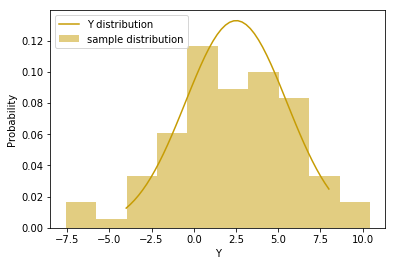

In [66]:
_ = plt.hist(y, bins = 10, normed=True, color = palette[4], alpha = 0.5, label = 'sample distribution')
plt.plot(np.linspace(-4, 8), 
         scipy.stats.norm.pdf(np.linspace(-4, 8), loc = k*np.mean(x), scale = s ),
         '-',
         color = palette[4],
        label = 'Y distribution')
plt.xlabel('Y')
plt.ylabel('Probability')
plt.legend(loc='upper left', bbox_to_anchor=(0., 1))

Let's set up Bayesian linear regression model following instructions [here](http://docs.pymc.io/notebooks/getting_started.html#A-Motivating-Example:-Linear-Regression) and [here](http://docs.pymc.io/notebooks/GLM-linear.html).

We choose zero-mean normal priors with variance of 100 for regression coefficients $\alpha$ and $\beta$, which corresponds to weak information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$:

$\alpha \sim N(0, 100)$

$\beta \sim N(0, 100)$

$\sigma \sim |N(0, 1)|$


In [60]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Normal('beta', mu=0, sd=5)
    sigma = pm.HalfNormal('sigma', sd=3)

    # Expected value of outcome
    mu = alpha + beta*x

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=y)

Let's now calculate posterior estimates.

In [61]:
with basic_model:
    # draw 1000 posterior samples
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1500/1500 [00:01<00:00, 887.10it/s]


Summary of the results

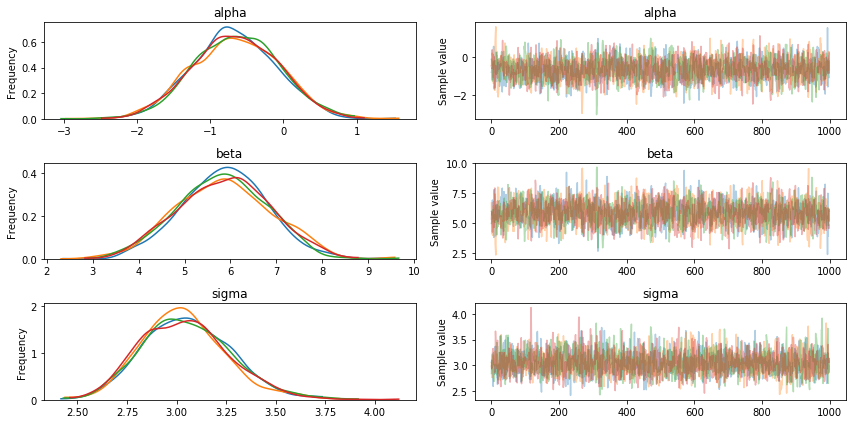

In [62]:
_ = pm.traceplot(trace)

In [77]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.658652,0.578140,0.011812,-1.759252,0.469500,1930.0,0.999869
beta,5.851133,0.999557,0.020260,3.973332,7.824244,2016.0,0.999884
sigma,3.046960,0.220221,0.004543,2.647999,3.489846,2249.0,1.000700


## Summary of the results

In [110]:
results = pd.DataFrame({'mean':[p[0], np.mean(slopes), pm.summary(trace)['mean']['beta'],p[1], 
                                np.mean(intercepts), pm.summary(trace)['mean']['alpha']], 
                       'std': [cov[0,0]**0.5, np.std(slopes), pm.summary(trace)['sd']['beta'],
                              cov[1,1]**0.5, np.std(intercepts), pm.summary(trace)['sd']['alpha']],
                       'method': ['LS', 'bootstrap', 'bayes', 'LS', 'bootstrap', 'bayes'],
                       'parameter': ['beta', 'beta','beta', 'alpha', 'alpha', 'alpha']})

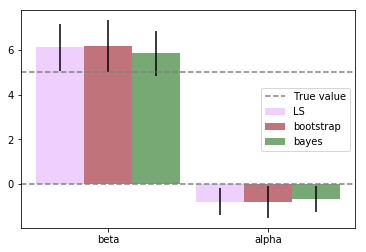

In [116]:
width = 0.3
i = 0
ind = np.arange(len(results.parameter.unique()))
for method in results.method.unique():
    plt.bar(ind + i*width, 
            results[results.method == method]['mean'].values, 
            width, 
            yerr = results[results.method == method]['std'].values,
            label = method,
            color = palette[i])
    i+=1
_ = plt.xticks(ind + width, results.parameter.unique())
plt.axhline(k, color = 'grey', linestyle = '--', label = 'True value')
plt.axhline(a, color = 'grey', linestyle = '--')

plt.legend(loc='best')

As you can see Bayesian estimates for the parameters are close to boostrapping and least square estimates, although Bayesian estimates come closer to their true values.